In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import logging
import os
import random
import re
import numpy as np
import torch

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def set_global_logging_level(level=logging.ERROR, prefixes=("",)):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        level: desired level. Optional. Default is logging.ERROR
        prefixes: list of one or more str prefixes to match (e.g. ["transformers", "torch"]). Optional.
            Default is `[""]` to match all active loggers.
            The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{"|".join(prefixes)})')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)

In [3]:
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# if logger.hasHandlers():
#     logger.handlers.clear()
# console = logging.StreamHandler()
# logger.addHandler(console)

logging.basicConfig(
    format='[%(asctime)s %(levelname)s %(name)s] %(message)s', datefmt='%m/%d %H:%M:%S',
    level=logging.INFO
)
set_global_logging_level(logging.WARNING, ["elasticsearch"])

set_seed(0)

In [4]:
from transformers import AutoConfig, AutoTokenizer
from models.reranker import Reranker
from utils.model_utils import load_state

tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator', use_fast=True,
                                          additional_special_tokens=['[unused0]', '[unused1]',
                                                                     '[unused2]', '[unused3]'])
reranker = Reranker('google/electra-base-discriminator')

[03/30 02:22:35 INFO transformers.file_utils] PyTorch version 1.4.0 available.
[03/30 02:22:37 INFO transformers.configuration_utils] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/google/electra-base-discriminator/config.json from cache at /home/xxx/.cache/torch/transformers/9236d197566a7f1be2b2151f5afcc5a8e17f31e1e23c52f3cdf2340019986e78.88ba6e8e7d5a7936e86d6f2551fe19c236dc57c24da163907cd0544e9933f6ee
[03/30 02:22:37 INFO transformers.configuration_utils] Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "summary_activation": "gelu",
  "summary_last_dropout": 0.

In [23]:
device = torch.device("cuda")
init_checkpoint = 'ckpts/rand-state-per-quest_electra-base-discriminator_DP0.5_HN2_M2_D2_adamW_SP0.5_B32_LR2.0e-05_WU0.1_E30_S42_03270146_td3-ila.4/checkpoint_pr.pt'
reranker = load_state(reranker, init_checkpoint, strict=False)
reranker.to(device)
reranker.eval()

Reranker(
  (encoder): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [6]:
from utils.data_utils import load_corpus_

corpus, title2id = load_corpus_('data/corpus/hotpot-paragraph-5.tsv', for_hotpot=True, require_hyperlinks=True)

[03/30 02:27:50 INFO utils.data_utils] Loaded 5232080 passages from data/corpus/hotpot-paragraph-5.tsv


In [26]:
from functools import partial
from torch.utils.data import DataLoader
from reranking_data import RerankingDataset, collate_qp

split = 'train'
is_strict = True
dataset = RerankingDataset(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.jsonl", tokenizer, corpus, title2id,
                           max_seq_len=512, max_q_len=96, max_obs_len=256, strict=is_strict)

In [27]:
batch_size = 32
collate_func = partial(collate_qp, pad_id=tokenizer.pad_token_id)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_func,
                        pin_memory=True, num_workers=0)

In [ ]:
from tqdm.notebook import tqdm
from utils.tensor_utils import to_device

para_scores = []
reranker.eval()
for batch in tqdm(dataloader):
    nn_input = to_device(batch['nn_input'], device)
    with torch.no_grad():
        para_logits = reranker(nn_input)
        para_probs = torch.cat(para_logits, dim=0).sigmoid()
        para_scores.extend(para_probs.tolist())
assert len(para_scores) == len(dataset)

In [40]:
import json

em = 0.
recall = 0.
hit = 0.
hn_nums = []
refined_examples = []
scored_examples = []
with open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.refined.tmp.jsonl", 'w') as f1, open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.scored.tmp.jsonl", 'w') as f2:
    for example in tqdm(dataset.examples):
        pair_offset, num_pair = example['pair_offset'], example['num_pair']
        sp_scores = []
        for para_score in para_scores[pair_offset:pair_offset + 2]:
            sp_scores.append(para_score)
        hn_scores = []
        for para_score in para_scores[pair_offset + 2:pair_offset + num_pair]:
            hn_scores.append(para_score)
        assert len(hn_scores) == len(example['hn_ids'])

        min_sp_score = min(sp_scores)
        sorted_hn_indices = sorted(list(range(len(hn_scores))), key=lambda idx: -hn_scores[idx])
        refined_hn_ids, refined_hn_scores = [], []
        for idx in sorted_hn_indices:
            if len(refined_hn_ids) >= 30:
                break
            if len(refined_hn_ids) < 15 or hn_scores[idx] >= min(min_sp_score, 0.1):
                refined_hn_ids.append(example['hn_ids'][idx])
                refined_hn_scores.append(hn_scores[idx])
            else:
                break
        hn_nums.append(len(refined_hn_ids))
        assert 15 <= len(refined_hn_ids) == len(refined_hn_scores) <= 30
        sorted_hn_ids, sorted_hn_scores = [], []
        for idx in sorted_hn_indices:
            sorted_hn_ids.append(example['hn_ids'][idx])
            sorted_hn_scores.append(hn_scores[idx])

#         if min_sp_score < 0.001:
#             print(sp_scores)
#         if len(refined_hn_ids) > 20:
#             print(sp_scores)
#             print(len(refined_hn_scores), refined_hn_scores)

        if min_sp_score > refined_hn_scores[0]:
            em += 1.
            recall += 1.
            hit += 1.
        elif max(sp_scores) > refined_hn_scores[1]:
            em += 0.
            recall += 0.5
            hit += 1.
        else:
            em += 0.
            recall += 0.
            hit += 0.

        refined_example = {
            "_id": example['_id'],
            "question": example['question'],
            "answer": example['answer'],
            "sp_facts": example['sp_facts'],
            "sp_ids": example['sp_ids'],
            "sp_scores": sp_scores,
            "hard_negs": refined_hn_ids,  # in- and out- neighbors of SPs, top ranked passages
            "hn_scores": refined_hn_scores,
            "state2action": example['state2action']
        }
        refined_examples.append(refined_example)
        f1.write(json.dumps(refined_example, ensure_ascii=False) + '\n')
        
        scored_example = {
            "_id": example['_id'],
            "question": example['question'],
            "answer": example['answer'],
            "sp_facts": example['sp_facts'],
            "sp_ids": example['sp_ids'],
            "sp_scores": sp_scores,
            "hard_negs": sorted_hn_ids,  # in- and out- neighbors of SPs, top ranked passages
            "hn_scores": sorted_hn_scores,
            "state2action": example['state2action']
        }
        scored_examples.append(scored_example)
        f2.write(json.dumps(scored_example, ensure_ascii=False) + '\n')

print(sum(hn_nums) / len(hn_nums))
print(em / len(dataset.examples) * 100, recall / len(dataset.examples) * 100, hit / len(dataset.examples) * 100)


15.535761274558581
87.06314195053457 93.33421782922595 99.60529370791734


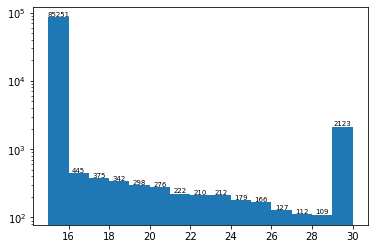

Max 30
Avg 15.535761274558581


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

counts, bins, patch = plt.hist(hn_nums, bins=15, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=8)
plt.show()
print(f"Max {max(hn_nums)}")
print(f"Avg {sum(hn_nums) / len(hn_nums)}")

In [44]:
# import json

em = 0.
recall = 0.
hit = 0.
hn_nums = []
refined_examples = []
split = 'dev'
with open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.refined.1.jsonl", 'w') as f1, open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.scored.1.jsonl") as f2:
    for line in f2:
        scored_example = json.loads(line)
        
        sp_scores = scored_example['sp_scores']
        hn_scores = scored_example['hn_scores']
        hard_negs = scored_example['hard_negs']
        assert len(hard_negs) == len(hn_scores)

        min_sp_score = min(sp_scores)
        sorted_hn_indices = sorted(list(range(len(hn_scores))), key=lambda idx: -hn_scores[idx])
        refined_hn_ids, refined_hn_scores = [], []
        for idx in sorted_hn_indices:
            if len(refined_hn_ids) >= 30:
                break
            if len(refined_hn_ids) < 15 or hn_scores[idx] >= min(min_sp_score, 0.1):
                refined_hn_ids.append(hard_negs[idx])
                refined_hn_scores.append(hn_scores[idx])
            else:
                break
        hn_nums.append(len(refined_hn_ids))
        assert 15 <= len(refined_hn_ids) == len(refined_hn_scores) <= 30
#         if min_sp_score < 0.001:
#             print(sp_scores)
#         if len(refined_hn_ids) > 20:
#             print(sp_scores)
#             print(len(refined_hn_scores), refined_hn_scores)

        if min_sp_score > refined_hn_scores[0]:
            em += 1.
            recall += 1.
            hit += 1.
        elif max(sp_scores) > refined_hn_scores[1]:
            em += 0.
            recall += 0.5
            hit += 1.
        else:
            em += 0.
            recall += 0.
            hit += 0.

        refined_example = {
            "_id": scored_example['_id'],
            "question": scored_example['question'],
            "answer": scored_example['answer'],
            "sp_facts": scored_example['sp_facts'],
            "sp_ids": scored_example['sp_ids'],
            "sp_scores": sp_scores,
            "hard_negs": refined_hn_ids,  # in- and out- neighbors of SPs, top ranked passages
            "hn_scores": refined_hn_scores,
            "state2action": scored_example['state2action']
        }
        refined_examples.append(refined_example)
        f1.write(json.dumps(refined_example, ensure_ascii=False) + '\n')

print(sum(hn_nums) / len(hn_nums))
print(em / len(refined_examples) * 100, recall / len(refined_examples) * 100, hit / len(refined_examples) * 100)

15.728966914247131
74.62525320729237 86.42808912896692 98.23092505064146


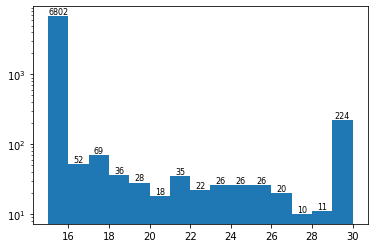

Max 30
Avg 15.728966914247131


In [45]:
# %matplotlib inline
# import matplotlib.pyplot as plt

counts, bins, patch = plt.hist(hn_nums, bins=15, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=8)
plt.show()
print(f"Max {max(hn_nums)}")
print(f"Avg {sum(hn_nums) / len(hn_nums)}")